# Import bibliotek

In [1]:
import json
import string
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import pandas as pd
import operator as op
import itertools as iter
from nltk.util import ngrams
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/piotrgrochala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/piotrgrochala/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Korpus dokumentów 

In [9]:
corpus_dir = 'streszczenie_original/'
corpus = PlaintextCorpusReader(corpus_dir, '.*\.txt')
files_names = corpus.fileids()
files_names

['Harry Potter i Czara Ognia.txt',
 'Harry Potter i Insygnia Smierci.txt',
 'Harry Potter i Kamien Filozoficzny.txt',
 'Harry Potter i Komnata Tajemnic.txt',
 'Harry Potter i Ksiaze Polkrwi.txt',
 'Harry Potter i Przeklete Dziecko.txt',
 'Harry Potter i Wiezien Azkabanu.txt',
 'Harry Potter i Zakon Feniksa.txt',
 'Opowiesci z Narni. Kon i jego chlopiec.txt',
 'Opowiesci z Narni. Ksiaze Kaspian.txt',
 'Opowiesci z Narni. Lew, czarownica i stara szafa.txt',
 'Opowiesci z Narni. Ostatnia bitwa.txt',
 'Opowiesci z Narni. Podroz Wedrowca do Switu.txt',
 'Opowiesci z Narni. Siostrzeniec Czarodzieja.txt',
 'Opowiesci z Narni. Srebrne krzeslo.txt',
 'Zmierzch.Ksiezyc w Nowiu.txt',
 'Zmierzch.Przed Switem.txt',
 'Zmierzch.Zacmienie.txt',
 'Zmierzch.Zmierzch.txt',
 'Zmierzch.Zycie i Smierc.txt']

# Wstępne przygotowanie dokumentów

In [10]:
documents = {}
for file in files_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Harry Potter i Czara Ognia.txt": "Lord Voldemort, wraz ze swoim sługą Glizdogonem przybywa do domu należącego niegdyś do rodziny Riddle'ów położonego w Little Hangleton. Tam układają plan dotyczący zamordowania Harry'ego Pottera, co ma pomóc Czarnemu Panu w odzyskaniu jego dawnej mocy. Jest także mowa o wiernym słudze Czarnego Pana, który wkrótce ma znaleźć się w Hogwarcie. Wszystko to słyszy mieszkający nieopodal ogrodnik, Frank Bryce. Voldemort odkrywając, iż mężczyzna podsłuchuje, zaprasza go do środka i uśmierca. Harry budzi się z przerażającego snu. Jego blizna pulsuje okropnym bólem. Próbuje sobie przypomnieć o czym śnił, a z pamięci wyłania się obraz mrocznego pokoju, węża leżącego przed kominkiem oraz Glizdogona i Lorda Voldemorta planujących morderstwo. Harry zastanawia się czy powinien komuś powiedzieć o problemach z blizną, ponieważ, gdy bolała go ostatnim razem, Voldemort wdarł się do Hogwartu. Ostatecznie postanawia napisać do Syriusza i zejść na śniadanie. W trakci

In [11]:
stoplist_file = open('stopwords_pl.txt', 'r', encoding='utf-8')
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [12]:
import ctypes
lib_path = "/Users/piotrgrochala/Dokumenty-nwi/TextMining/.venv/lib/python3.9/site-packages/morfeusz2-1.99.8-py3-macosx-10.9-x86_64.egg/libmorfeusz2.dylib"
lib = ctypes.CDLL(lib_path)
print("Library loaded successfully!")


Library loaded successfully!


In [13]:
def lemmatize(text):
    morf = lib.morfeusz2.Morfeusz()
    segments = iter.groupby(morf.analyse(text), op.attrgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma, descr, _, _, )in group)
        perpl, lemma = min(pairs)
        return lemma.split(':')[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return ' '.join(filter(str.isalpha, lemmas))


In [14]:
def lemmatize(text):
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text, language="polish")
    # Return only alphabetic tokens.
    lemmas = [token for token in tokens if token.isalpha()]
    return " ".join(lemmas)

In [15]:
# morf = lib.morfeusz2.Morfeusz()
# morf.analyse("Ala ma kota")

In [16]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])
    

# Utworzenie macierzy częstości

In [17]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

content
Harry Potter i Czara Ognia.txt                      lord voldemort wraz swoim sługą glizdogonem pr...
Harry Potter i Insygnia Smierci.txt                 podczas zebrania śmierciożerców odbywa dworze ...
Harry Potter i Kamien Filozoficzny.txt              ulicy privet drive pojawia stary człowiek dług...
Harry Potter i Komnata Tajemnic.txt                 wuj vernon zły hedwiga robi bałagan domu tymcz...
Harry Potter i Ksiaze Polkrwi.txt                   mugolskiego premiera odwiedza korneliusz knot ...
Harry Potter i Przeklete Dziecko.txt                scena pierwsza druga opowiada historię została...
Harry Potter i Wiezien Azkabanu.txt                 harry leży kocami łóżku odrabia prace domowe z...
Harry Potter i Zakon Feniksa.txt                    dudley zły wyżywa harrym dudley zostaje zaatak...
Opowiesci z Narni. Kon i jego chlopiec.txt          akcja książki rozgrywa narnii czasów panowania...
Opowiesci z Narni. Ksiaze Kaspian.txt               mija rok wydarzeń opisanych powieści lew czaro...
Opowiesci z Narni. Lew, czarownica i stara szaf...  rok wielka brytania piotr zuzanna edmund łucja...
Opowiesci z Narni. Ostatnia bitwa.txt               julia eustachy zostają wezwani narnii pomóc za...
Opowiesci z Narni. Podroz Wedrowca do Switu.txt     łucja edmund przyjechali swego kuzyna eustache...
Opowiesci z Narni. Siostrzeniec Czarodzieja.txt     książka opisuje stworzenie narnii aslana czym ...
Opowiesci z Narni. Srebrne krzeslo.txt              pewnego dnia eustachy scrubb szkolna koleżanka...
Zmierzch.Ksiezyc w Nowiu.txt                        kontynuacja losów bohaterów powieści filmu zmi...
Zmierzch.Przed Switem.txt                           przygotowania ślubu idą pełną parą bella martw...
Zmierzch.Zacmienie.txt                              edward cullen ukochana bella swan znowu razem ...
Zmierzch.Zmierzch.txt                               zmierzch opowiada historię belli swan przeprow...
Zmierzch.Zycie i Smierc.txt                         odzwierciedlając fabułę twilight life and deat...

In [18]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0318953 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05104483, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Chmury tagów

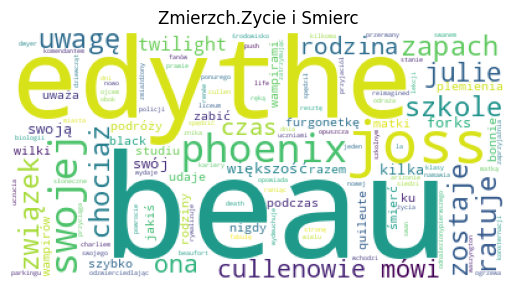

In [21]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue',
)
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace('.txt', ''))
    plt.savefig(f'wordclouds/{index.replace(".txt", "")}.png', format='png')

# Topic modelling

In [22]:

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f'topics/{title}.png', format='png')

In [23]:
n_components = 3
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
subplots = [1,5]


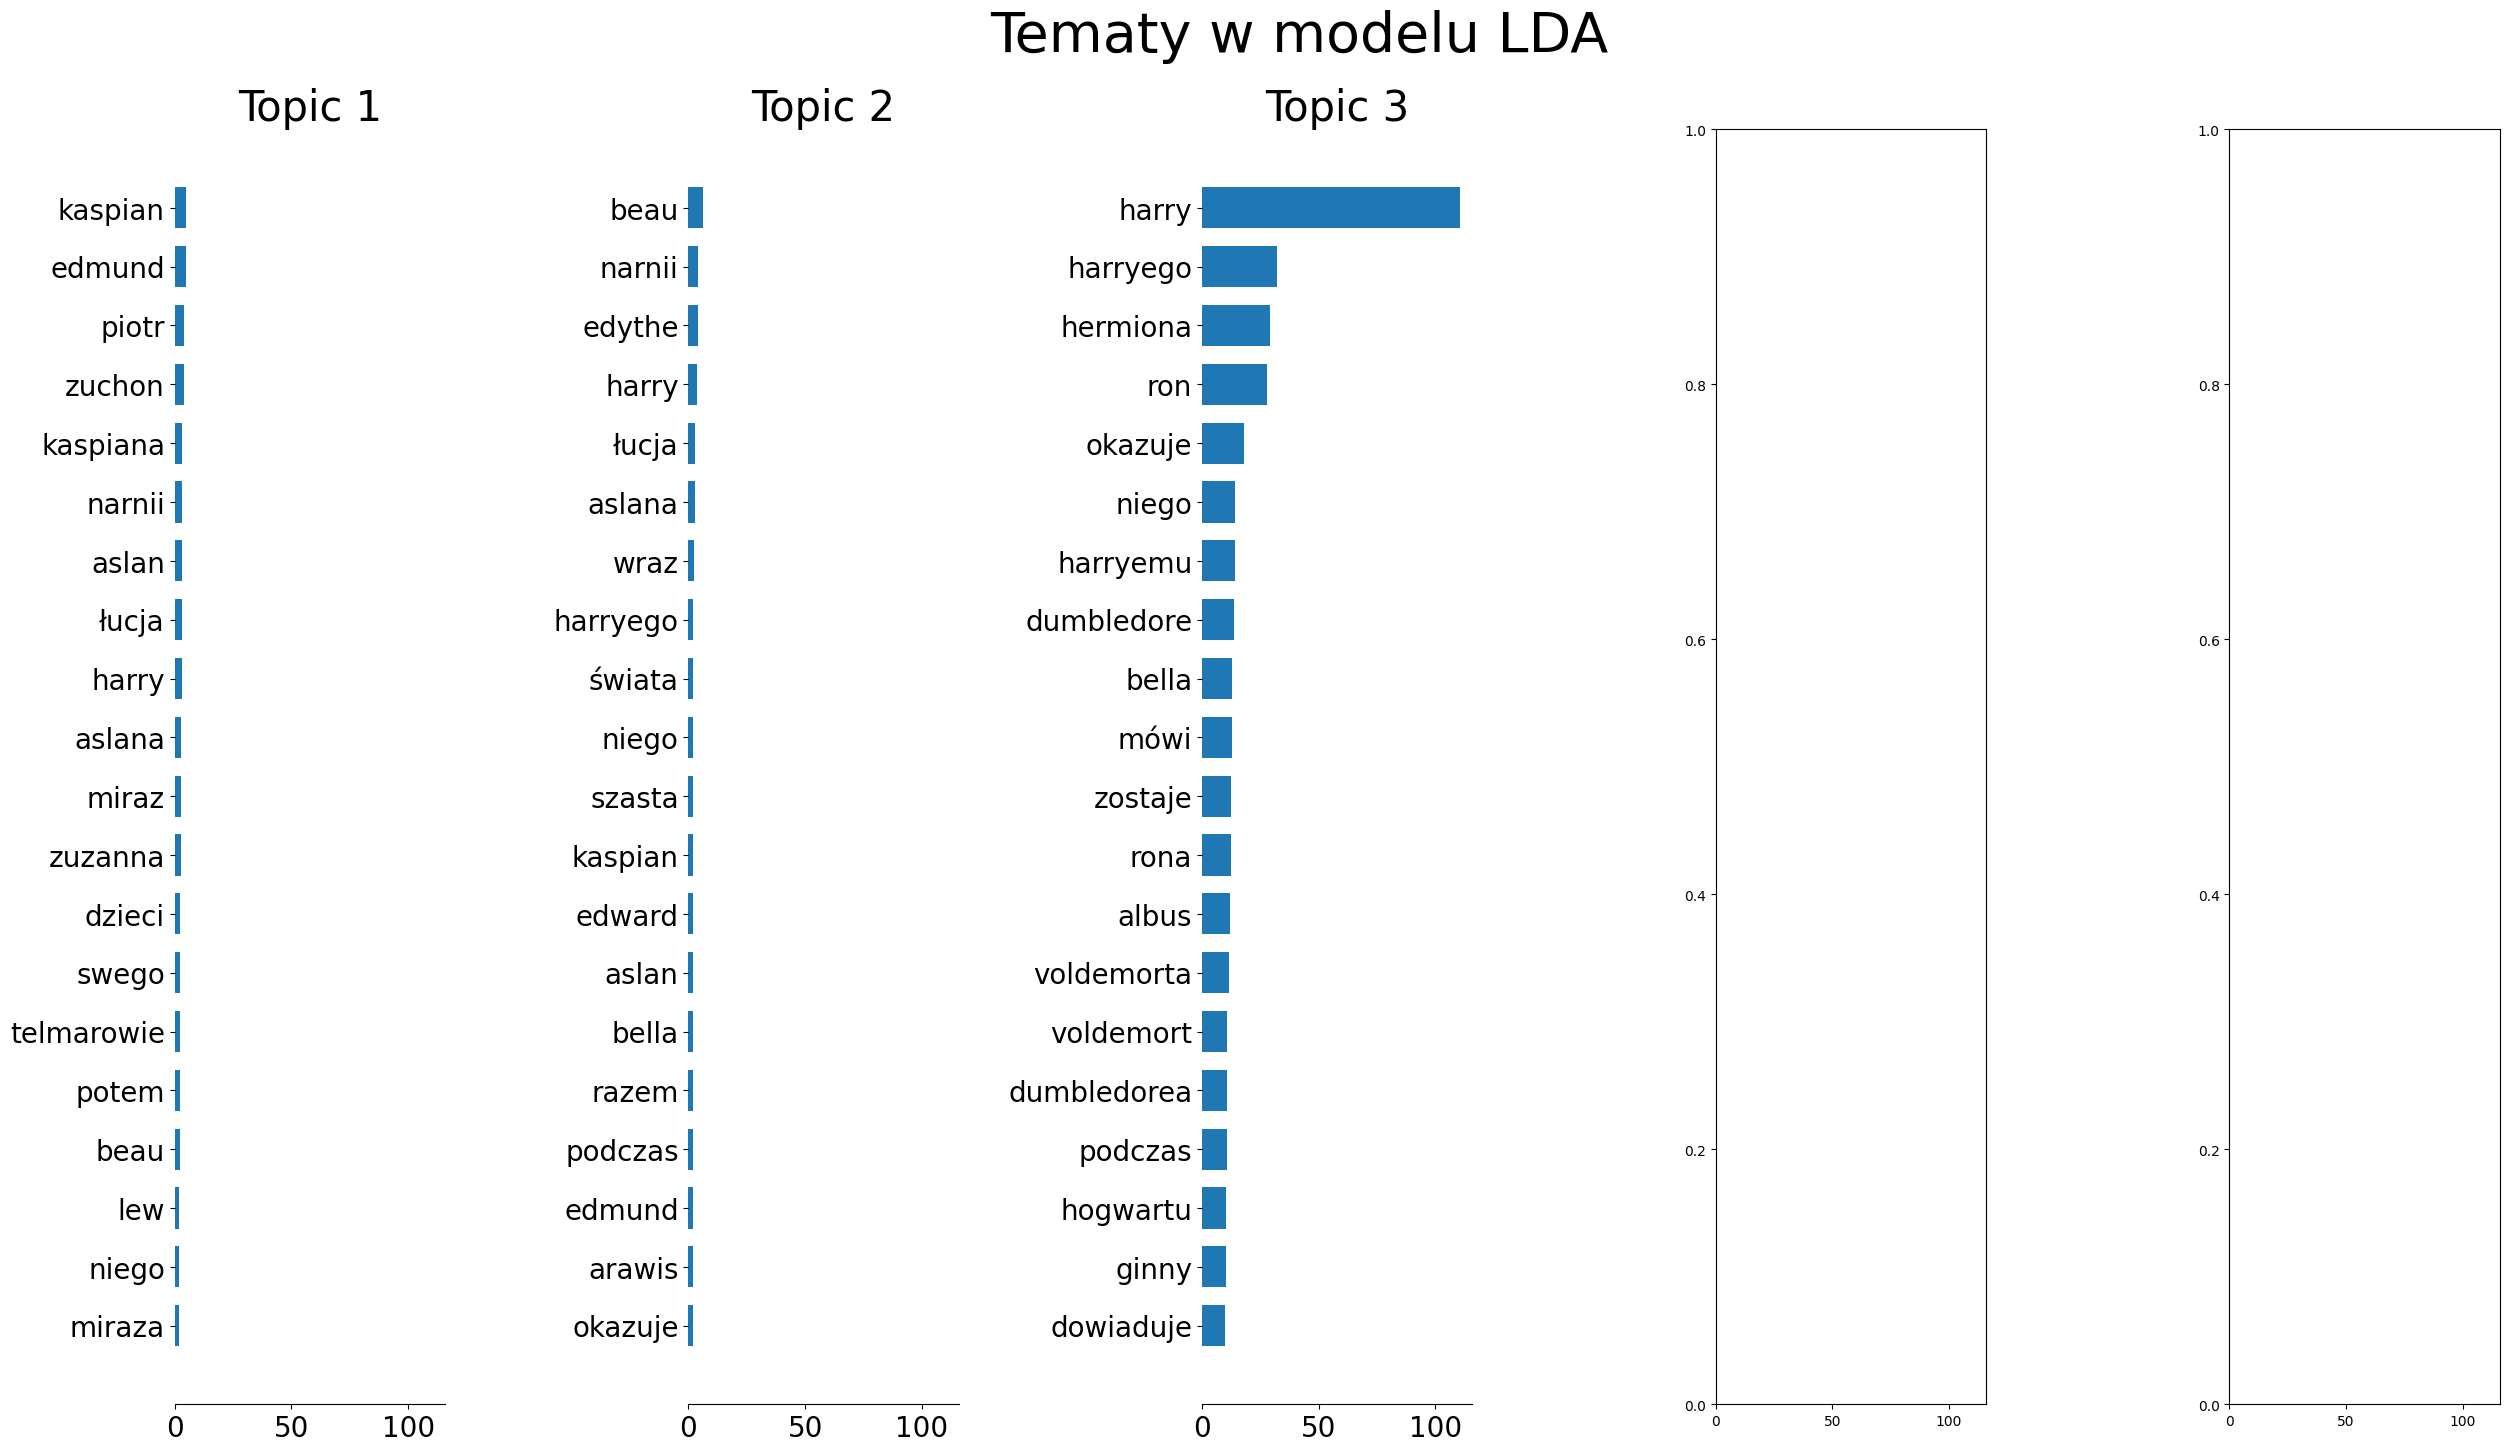

In [25]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0,
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA")

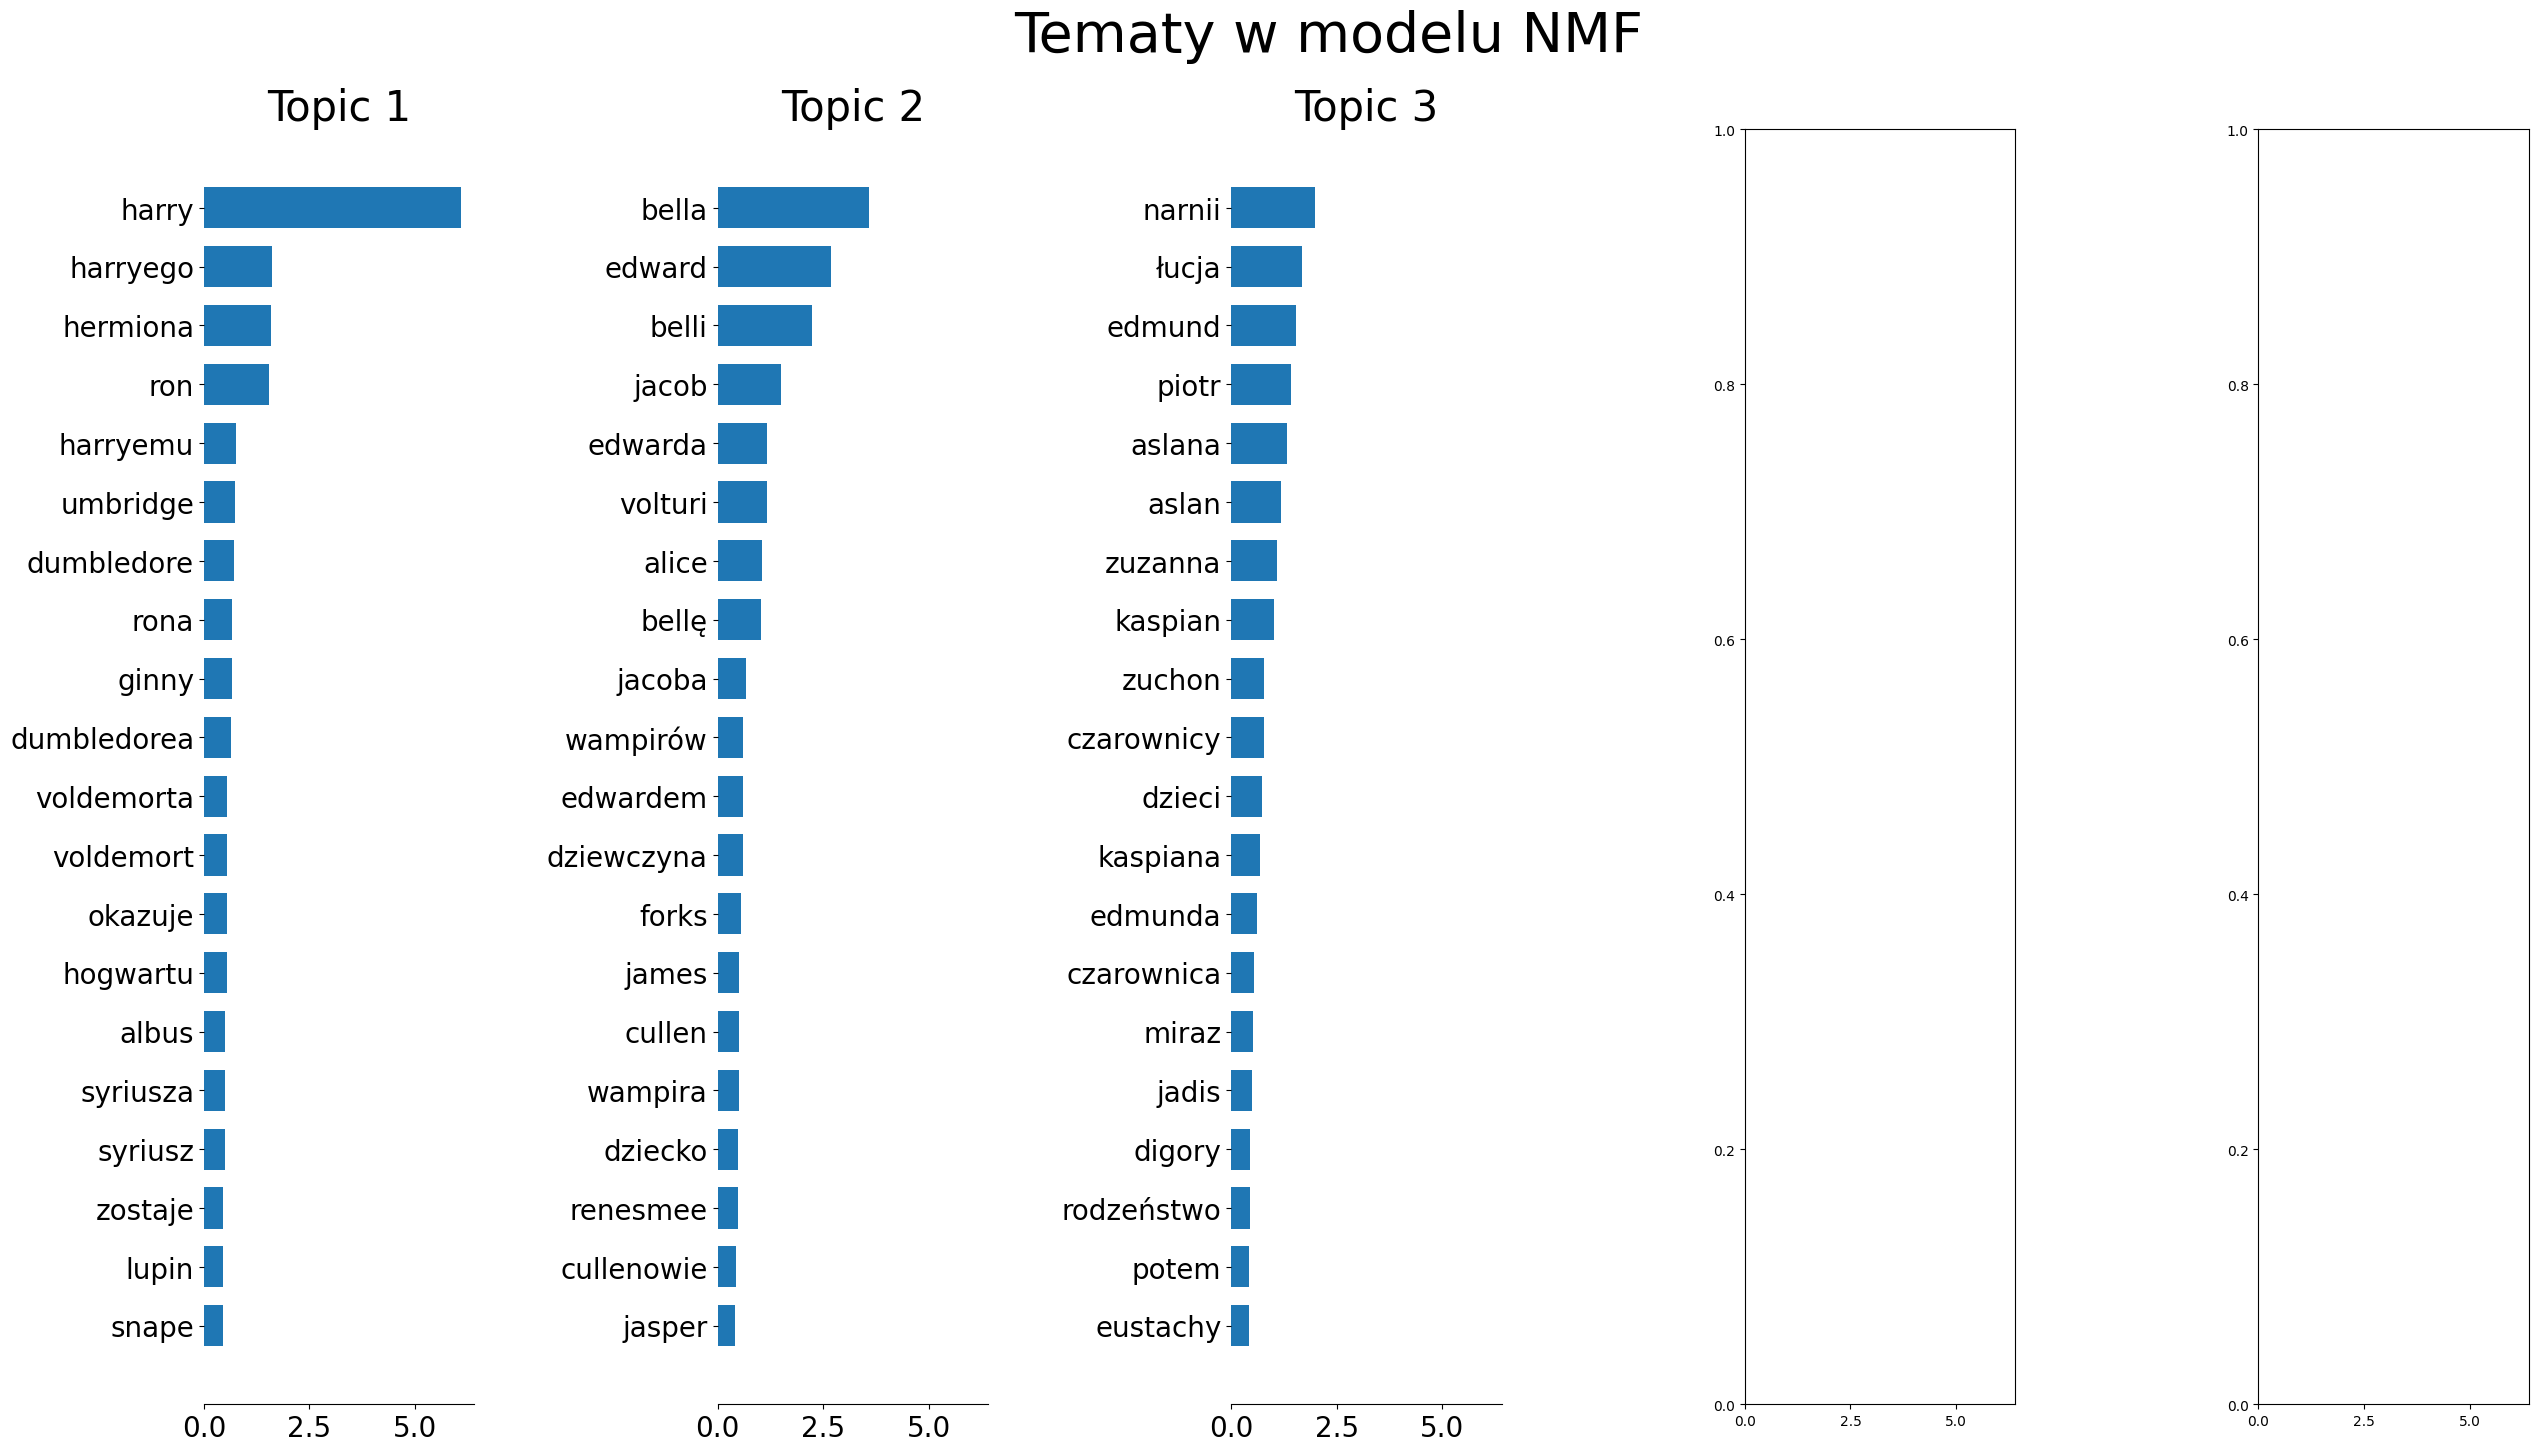

In [26]:
nmf_fm = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=0.00005,
    alpha_W=0.00005,
    l1_ratio=0.5,
)

nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF")

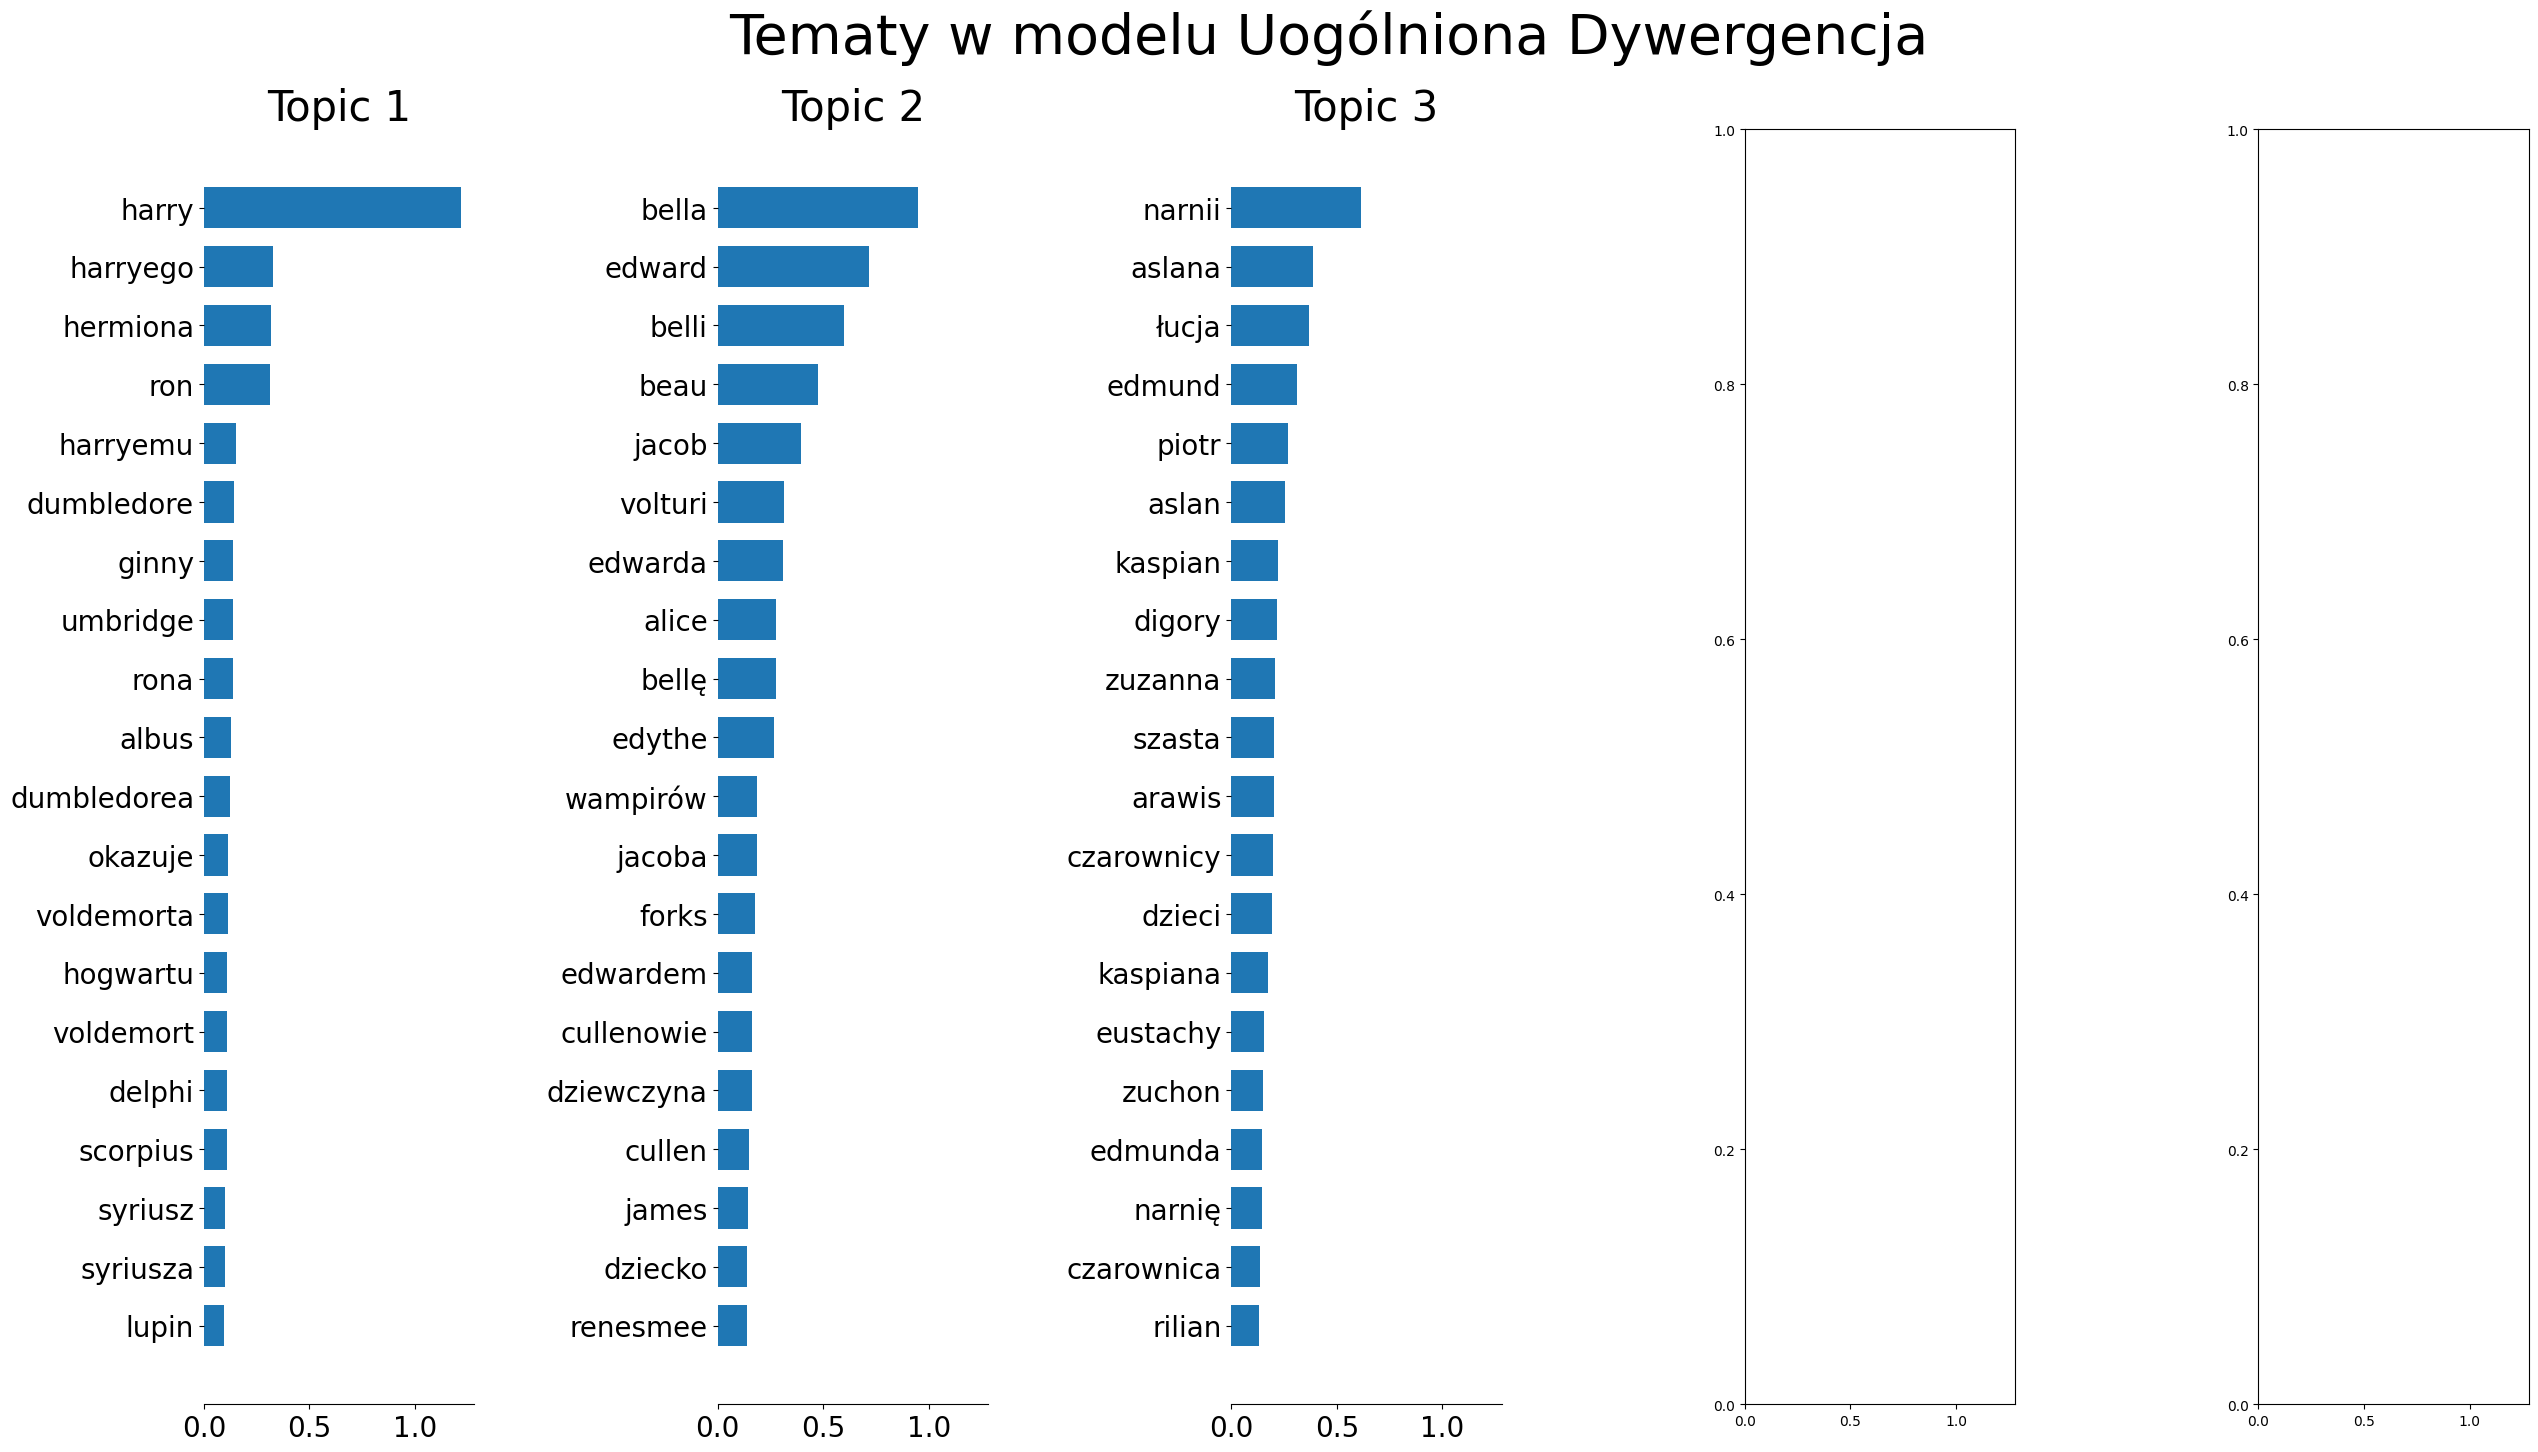

In [27]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=0.00005,
    alpha_W=0.00005,
    l1_ratio=0.5,
)

nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu Uogólniona Dywergencja")

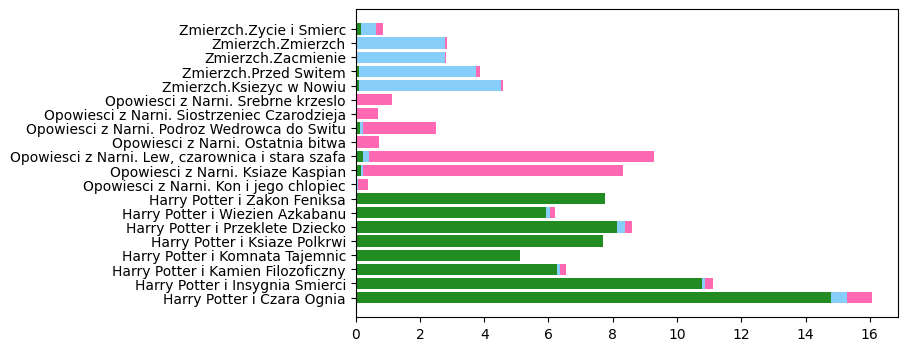

In [28]:
docs_topics = pd.DataFrame(nmf_fm.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, color=colors[i], label=col)
    left = [left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

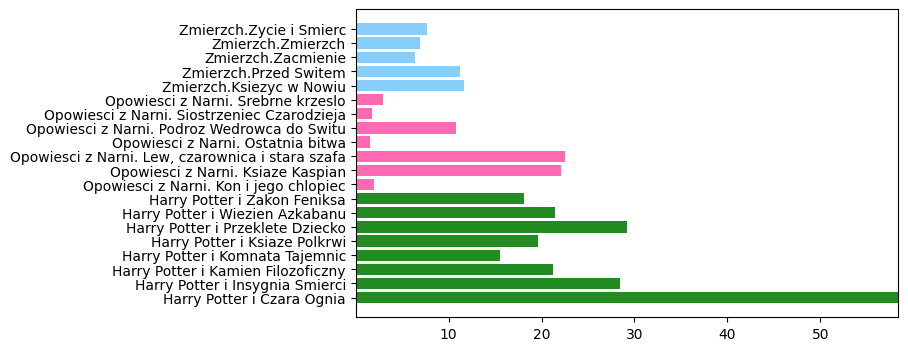

In [29]:
docs_topics = pd.DataFrame(nmf_kl.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, color=colors[i], label=col)
    left = [left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

# Analiza skupień

In [30]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [31]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(20,20)
cs

array([[1.        , 0.53243755, 0.43885169, 0.41169169, 0.4957081 ,
        0.35779609, 0.45814585, 0.48597307, 0.0290178 , 0.05726577,
        0.06669179, 0.03328349, 0.07414816, 0.0265431 , 0.03270183,
        0.04987295, 0.04925221, 0.0420351 , 0.03845789, 0.02587446],
       [0.53243755, 1.        , 0.48488615, 0.46678341, 0.5800137 ,
        0.38415022, 0.46290914, 0.58420817, 0.02620746, 0.04851535,
        0.05625166, 0.04484428, 0.04066479, 0.01790585, 0.02914307,
        0.04064248, 0.03348224, 0.03022905, 0.02930276, 0.02364513],
       [0.43885169, 0.48488615, 1.        , 0.41103422, 0.43668932,
        0.32263945, 0.38298252, 0.44123387, 0.02312014, 0.04665265,
        0.06187129, 0.0172577 , 0.05324704, 0.01385909, 0.02511717,
        0.03554966, 0.03312227, 0.02598401, 0.03296424, 0.02368545],
       [0.41169169, 0.46678341, 0.41103422, 1.        , 0.48424034,
        0.29982086, 0.36033559, 0.4377684 , 0.01872472, 0.03269131,
        0.03834894, 0.01833928, 0.03187163, 0

In [32]:
clustering = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward',
    compute_distances=True
).fit(cs)
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0])

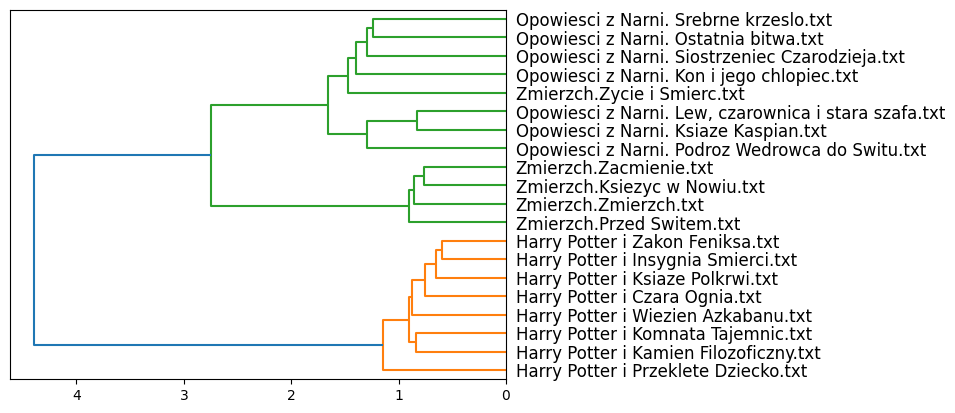

In [33]:
plot_dendrogram(
    clustering,
    labels = files_names,
    truncate_mode='level',
    orientation='left',
)
plt.show()

In [34]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(20,20)
ed

array([[  0.        , 103.08734161, 116.91022197, 122.04097673,
        110.76100397, 124.30607387, 116.94015564, 112.47221879,
        146.0205465 , 153.90906406, 154.95160535, 145.97602543,
        145.9965753 , 146.1984952 , 146.12665739, 147.95269514,
        147.49576265, 146.76852524, 146.85366866, 148.82876066],
       [103.08734161,   0.        ,  75.84853328,  78.59389289,
         69.02897942,  92.84934033,  78.38367177,  69.05794668,
        101.24722218, 114.80853627, 117.05127082, 100.98514742,
        103.51811436, 101.50369451, 101.40019724, 105.47511555,
        104.95713411, 102.76186063, 103.19399207, 105.59829544],
       [116.91022197,  75.84853328,   0.        ,  54.80875842,
         62.09669879,  85.83705494,  59.94163828,  62.5299928 ,
         65.77233461,  87.21238444,  90.29950166,  65.8559033 ,
         69.70652767,  66.        ,  66.27971032,  73.430239  ,
         72.13182377,  68.72408603,  68.77499546,  73.10266753],
       [122.04097673,  78.59389289,  

In [35]:
clustering = AgglomerativeClustering(
    n_clusters=3,
    metric='precomputed',
    linkage='complete',
    compute_distances=True
).fit(ed)
clustering.labels_

array([1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

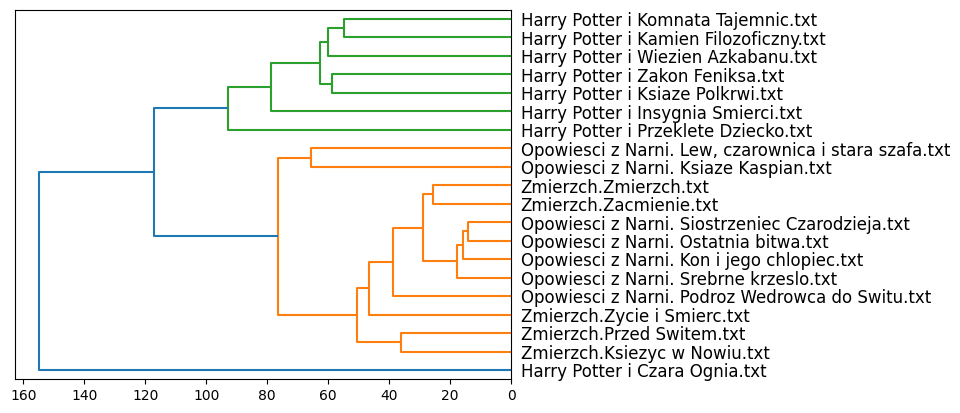

In [36]:
plot_dendrogram(
    clustering,
    labels = files_names,
    truncate_mode='level',
    orientation='left',
)
plt.show()

# N-gramy

In [37]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{
    "Harry Potter i Czara Ognia.txt": [
        "lord",
        "voldemort",
        "wraz",
        "swoim",
        "sługą",
        "glizdogonem",
        "przybywa",
        "domu",
        "należącego",
        "niegdyś",
        "rodziny",
        "riddleów",
        "położonego",
        "little",
        "hangleton",
        "układają",
        "plan",
        "dotyczący",
        "zamordowania",
        "harryego",
        "pottera",
        "pomóc",
        "czarnemu",
        "panu",
        "odzyskaniu",
        "dawnej",
        "mocy",
        "mowa",
        "wiernym",
        "słudze",
        "czarnego",
        "pana",
        "wkrótce",
        "znaleźć",
        "hogwarcie",
        "słyszy",
        "mieszkający",
        "nieopodal",
        "ogrodnik",
        "frank",
        "bryce",
        "voldemort",
        "odkrywając",
        "mężczyzna",
        "podsłuchuje",
        "zaprasza",
        "środka",
        "uśmierca",
        "harry",
        "budzi",

In [38]:
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], 3)).value_counts()
    print(list(ngrams(documents[title], 3)))
    print(n_gram[:5])

[('l', 'o', 'r'), ('o', 'r', 'd'), ('r', 'd', ' '), ('d', ' ', 'v'), (' ', 'v', 'o'), ('v', 'o', 'l'), ('o', 'l', 'd'), ('l', 'd', 'e'), ('d', 'e', 'm'), ('e', 'm', 'o'), ('m', 'o', 'r'), ('o', 'r', 't'), ('r', 't', ' '), ('t', ' ', 'w'), (' ', 'w', 'r'), ('w', 'r', 'a'), ('r', 'a', 'z'), ('a', 'z', ' '), ('z', ' ', 's'), (' ', 's', 'w'), ('s', 'w', 'o'), ('w', 'o', 'i'), ('o', 'i', 'm'), ('i', 'm', ' '), ('m', ' ', 's'), (' ', 's', 'ł'), ('s', 'ł', 'u'), ('ł', 'u', 'g'), ('u', 'g', 'ą'), ('g', 'ą', ' '), ('ą', ' ', 'g'), (' ', 'g', 'l'), ('g', 'l', 'i'), ('l', 'i', 'z'), ('i', 'z', 'd'), ('z', 'd', 'o'), ('d', 'o', 'g'), ('o', 'g', 'o'), ('g', 'o', 'n'), ('o', 'n', 'e'), ('n', 'e', 'm'), ('e', 'm', ' '), ('m', ' ', 'p'), (' ', 'p', 'r'), ('p', 'r', 'z'), ('r', 'z', 'y'), ('z', 'y', 'b'), ('y', 'b', 'y'), ('b', 'y', 'w'), ('y', 'w', 'a'), ('w', 'a', ' '), ('a', ' ', 'd'), (' ', 'd', 'o'), ('d', 'o', 'm'), ('o', 'm', 'u'), ('m', 'u', ' '), ('u', ' ', 'n'), (' ', 'n', 'a'), ('n', 'a', 'l

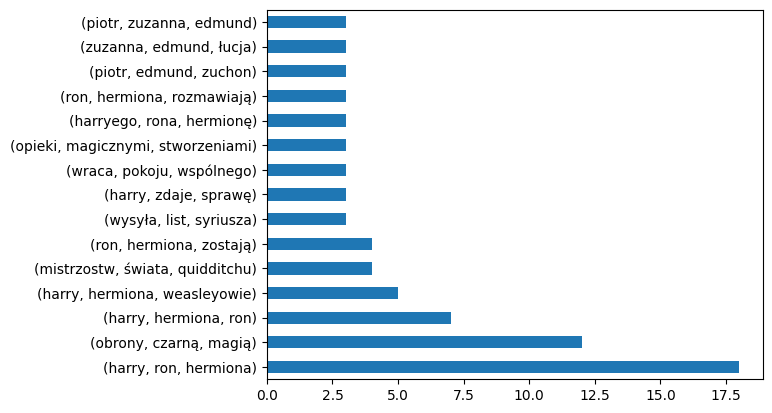

In [39]:
texts = ' '.join(docs['content']).split(' ')
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.show()